# archパッケージのForecastingを使ってみる

[Forecasting](https://arch.readthedocs.io/en/latest/univariate/forecasting.html)

### Analytical forecasts
- 全てのARCH系モデルに対して、1ステップ先のAnalytical Forecastsが利用できる。GARCHやHARCH等の残差の2乗について線形なモデルの場合にのみ複数ステップ先までの予測ができる。
- この予測では、撹乱項のホワイトノイズについてはサンプリングせずランダム性を排除している（あれ、でも期待値を使うなら0になってしまうから予測は常に0だし、1にする場合はホワイトノイズの期待値が1になるから本来のモデルとは違う分布になってしまうんじゃない？？？）

### Simulation-based forecasts
- 多分、`model.forecast(method='simulation')`と`model.simulate()`は同じ。だから「seq-data-analysis-training-08-VaR-simulation.ipynb」でやったのはこれ。

### Bootstrap-based forecasts

In [1]:
%matplotlib inline

import arch
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Sans'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as ss
import statsmodels.tsa as tsa
from statsmodels.sandbox.stats import runs
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# E-Mini S&P500先物と金先物データ読み込み

In [2]:
dfsp_tmp = pd.read_csv('data/e-mini-sp500-200530/e-mini-sp500-daily.csv')
dfg_tmp = pd.read_csv(f'data/gold-200626/gold-daily.csv')
dfs = [dfsp_tmp, dfg_tmp]

prods = ['S&P500先物', '金先物']

# datetime indexに変換
def to_datetime_index(df):
    # DateTime列を追加
    df['datetime'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    df = df.set_index('datetime', drop=True)
    df = df.drop(columns=['Date', 'Time'])
    return df

dfs = [to_datetime_index(df) for df in dfs]

# 対数変換した列を追加
def add_log_values(df):
    df['logO'] = np.log(df['Open'])
    df['logH'] = np.log(df['High'])
    df['logL'] = np.log(df['Low'])
    df['logC'] = np.log(df['Close'])
    df['logV'] = np.log(df['Vol'])
    df['logOI'] = np.log(df['OI'])

_ = [add_log_values(df) for df in dfs]

/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/leo/src/pyproject/sandbox/.venv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 価格、対数価格、価格階差、対数差収益率（100倍）のDFを作成

In [3]:
def to_log_return_ratio_df(df):
    diff_df = df.diff()
    close_df = df[['Close', 'logC']]
    diff_df = diff_df.rename(columns={'Close': 'CloseDiff', 'logC': 'logCDiff'})
    close_diff_df = diff_df[['CloseDiff', 'logCDiff']]
    close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
    rr_df = pd.concat([close_df, close_diff_df], axis=1)
    rr_df = rr_df.dropna()
    return rr_df

rr_dfs = [to_log_return_ratio_df(df) for df in dfs]

<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100
<ipython-input-3-05b88fa8d3aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_diff_df['logCDiff'] = close_diff_df['logCDiff'] * 100


# 2019年以降のデータ

In [58]:
rrdfs2019 = [df[dt.datetime(2019, 1, 1):dt.datetime(2020, 3, 1)] for df in rr_dfs]

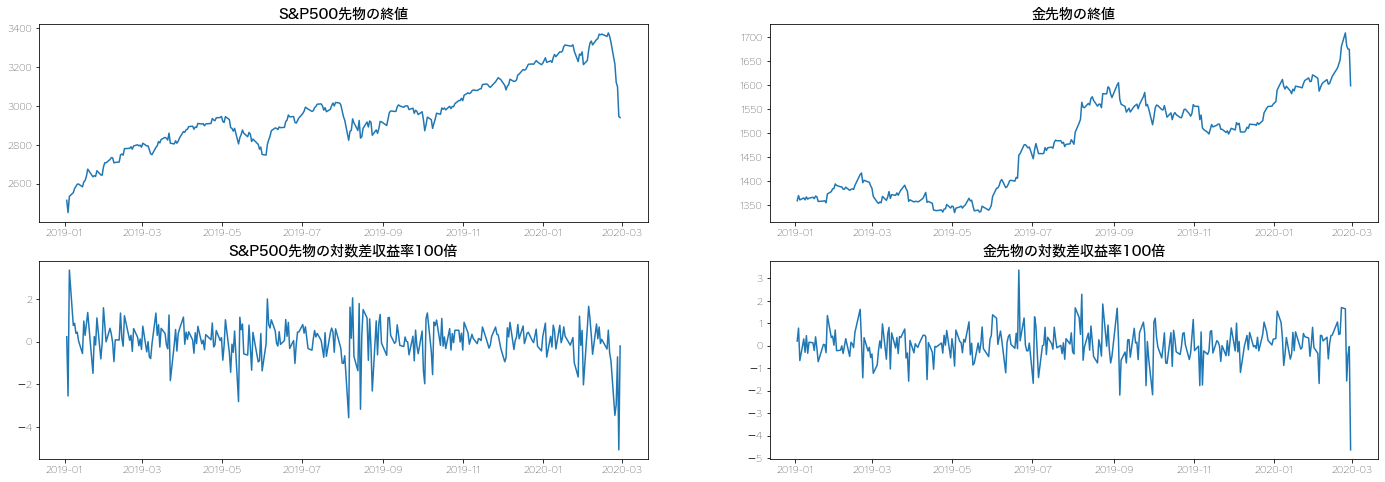

In [59]:
# 比較のため価格と対数差収益率を可視化しておく
fig, ax = plt.subplots(2, 2, figsize=(24,8))
for i, prod in enumerate(prods):
    ax[0,i].plot(rrdfs2019[i].index, rrdfs2019[i]['Close'])
    ax[0,i].set_title(f'{prod}の終値', fontsize=14, fontweight='semibold')
    ax[1,i].plot(rrdfs2019[i].index, rrdfs2019[i]['logCDiff'])
    ax[1,i].set_title(f'{prod}の対数差収益率100倍', fontsize=14, fontweight='semibold')

# GARCHモデルのあてはめ

現状最もAICが小さいモデルは**EGARCH**だが、今回はAnalytical Forecastsも試したいため、**GARCH**を使う。当てはめには、2019年のデータのみを使う。2020年以降のデータは予測性能評価用に分けておく。

S%P500先物データにEGARCHを使う根拠
- 定常時系列とみなせる（ARXモデルを使うための条件）
    - Dicker-Fuller検定にかけた結果、単位根を持つという帰無仮説を棄却できたため
- 分散不均一性を持つ（ARCH/GARCH等を使うための条件）
    - ARモデルにあてはめたところ、誤差分散（残差の2乗）系列に時間依存構造があったため
- 価格の上昇・下落に対してボラティリティ変動が非対称だと想定される（GJR GARCHも可）
    - 株式市場では一般に、価格が上昇した時より下落したときにボラティリティが上昇することが知られているため

In [60]:
split_date = dt.datetime(2020, 1, 1)
garch_models = [arch.arch_model(df['logCDiff'], vol='GARCH', dist='gaussian', p=1, o=1, q=1) for df in rrdfs2019]
garesults = [am.fit(last_obs=split_date, disp='off') for am in garch_models]
_ = [print(f'{prod}にGARCH(1,1,1)モデルを当てはめたときのAIC：{res.aic}') for res, prod in zip(garesults, prods)]
_ = [print(res.summary()) for res in garesults]

S&P500先物にGARCH(1,1,1)モデルを当てはめたときのAIC：551.0514820877754
金先物にGARCH(1,1,1)モデルを当てはめたときのAIC：533.2187374019385
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:               logCDiff   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -270.526
Distribution:                  Normal   AIC:                           551.051
Method:            Maximum Likelihood   BIC:                           568.699
                                        No. Observations:                  252
Date:                Wed, Nov 04 2020   Df Residuals:                      247
Time:                        19:29:54   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------

# Analytical forecast

https://arch.readthedocs.io/en/latest/univariate/forecasting.html#analytical-forecasts

ここで使っているGARCHモデルはconstant meanモデルだから、予測するときに平均値の予測値はプロット不要（常に一定値を予測するため）。分散の予測（と必要なら残差の分散の予測）のプロットだけで良い。

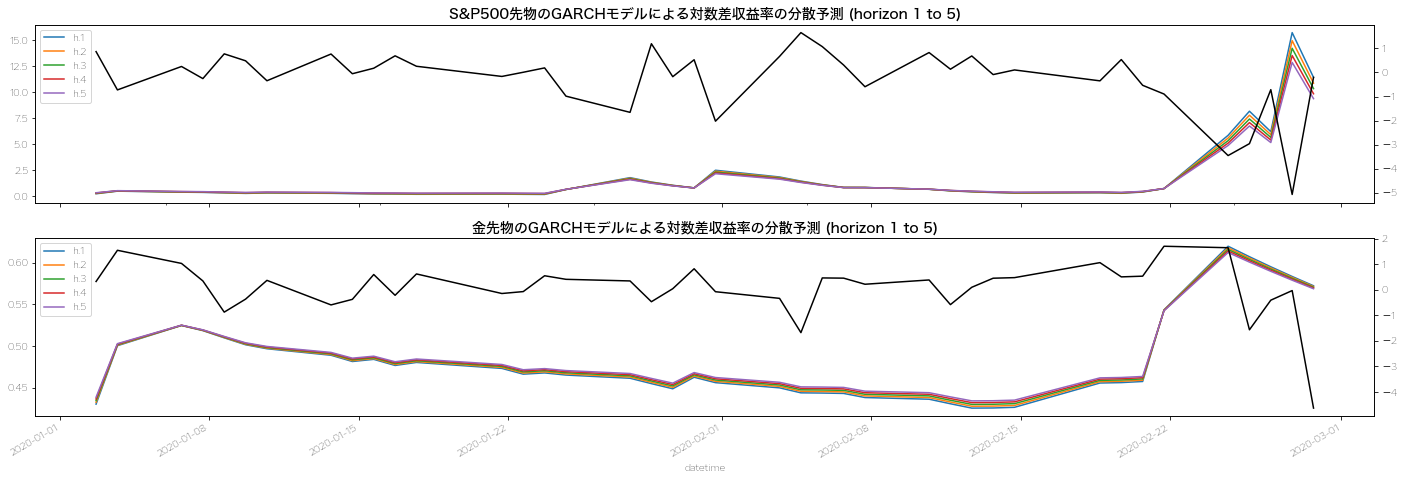

In [76]:
'''
各ステップからその先1〜5ステップまでを予測している（h.NはNステップ先の分散の予測値）
右軸は、各価格系列の対数差収益率（黒折れ線）をプロットした。
2月22日あたりからコロナで暴落しているが、分散予測値も非常に大きくなっていることがわかる。

ARCH系モデルは分散のモデルが定常条件に収まっていれば、撹乱項が確率的に大きくなる時を除いて、分散は減衰していく。
実際、h1 --> h5 と予測時点が先に進むにつれて分散予測値が小さくなっていることがわかる。
（Analytical Forecastingでは撹乱項について期待値を取るため確率的な変動を排除している）

つまりAnalytical Forecastingは分散の期待値がどう減衰していくかを予測する。
これがシステムトレードのためのシグナルとして役に立つとは思えない。
なぜなら、このモデルはいつでも未来の価格の分散が徐々に減衰していくにつれて対数差収益率も徐々に0に近づいていくことを予測するだけだから。
あとはパラメータの値によってその減衰の仕方が違うだけ。
この予測は対数差収益率に対するものだから、価格系列としても、徐々に変化がなくなっていくことを予測するだけ。

この予測性能を評価する場合、実際の分散との平均2乗誤差をとることになるのか。
でも実際の分散はどの範囲で計算すべきなのかがわからない。

Analytical Forecastsをシステムトレードのためのシグナルとして利用することはできるのか。不明。
'''
ga_forecasts = [res.forecast(horizon=5, start=split_date) for res in garesults]

fig, ax = plt.subplots(2, 1, figsize=(24, 8))
right_ax = []
for i, prod in enumerate(prods):
    ga_forecasts[i].variance[split_date:].plot(ax=ax[i])
    ax[i].set_title(f'{prod}のGARCHモデルによる対数差収益率の分散予測 (horizon 1 to 5)', fontsize=14, fontweight='semibold')
    right_ax.append(ax[i].twinx())
    right_ax[i].plot(rrdfs2019[i][split_date:].index, rrdfs2019[i][split_date:]['logCDiff'], color='black')
    ax[i].legend(loc=2)